In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [24]:
load = pd.read_csv('C:/Users/volco/AdvancedBA/Data/load.csv')
prices = pd.read_csv('C:/Users/volco/AdvancedBA/Data/prices.csv')
res_gen = pd.read_csv('C:/Users/volco/AdvancedBA/Data/res_gen.csv')
residual_gen = pd.read_csv('C:/Users/volco/AdvancedBA/Data/residual_generation.csv')

load['date'] = pd.to_datetime(load['date'])
prices['date'] = pd.to_datetime(prices['date'])
res_gen['date'] = pd.to_datetime(res_gen['date'])
residual_gen['date'] = pd.to_datetime(residual_gen['date'])

# Convert all price columns to numeric, coercing errors to NaN for non-numeric values in 'price_FRA'
for col in ['price_AT', 'price_BE', 'price_FRA', 'price_GER', 'price_NL']:
    prices[col] = pd.to_numeric(prices[col], errors='coerce')

missing_values_prices = prices.isnull().sum()

prices.fillna(prices.mean(), inplace=True)

In [16]:
import numpy as np
import pandas as pd


# Assuming we're focusing on one region for simplicity
prices = prices['price_BE'].values  # Example: Focusing on Belgium

# Discretize prices into categories (low, medium, high) for simplicity
price_bins = pd.qcut(prices, q=3, labels=False, duplicates='drop')

# Parameters
battery_capacity = 100  # kWh
charge_discharge_rate = 10  # kW per hour
total_hours = len(prices)  # Total simulation hours

# Q-Table: Rows are states (battery levels + price levels), columns are actions (charge, discharge, do nothing)
num_battery_levels = 11  # 0-100% in 10% increments
num_price_levels = len(np.unique(price_bins))  # Number of unique price levels
num_actions = 3  # Charge, discharge, do nothing

# Initialize Q-table with zeros
Q = np.zeros((num_battery_levels * num_price_levels, num_actions))

# Learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate


In [17]:
def get_state_index(battery_level, price_level):
    """Calculate the index of the state in the Q-table."""
    return battery_level * num_price_levels + price_level

def choose_action(state_index):
    """Choose an action based on the epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)  # Explore
    else:
        return np.argmax(Q[state_index])  # Exploit

def update_q_table(state_index, action, reward, next_state_index):
    """Update Q-table using the Q-learning algorithm."""
    best_next_action = np.argmax(Q[next_state_index])
    td_target = reward + gamma * Q[next_state_index][best_next_action]
    td_error = td_target - Q[state_index][action]
    Q[state_index][action] += alpha * td_error

# Simulation loop
for hour in range(1, total_hours):
    # Assume battery level is discretized in 10% steps for simplicity
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    price_level = price_bins[hour]  # Current price level
    
    state_index = get_state_index(battery_level, price_level)
    action = choose_action(state_index)  # Choose action based on the policy
    
    # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
    reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
    
    # Update battery level based on action (simplified, without actual consumption or charging logic)
    battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
    
    next_price_level = price_bins[hour + 1] if hour + 1 < total_hours else price_bins[hour]
    next_state_index = get_state_index(battery_level, next_price_level)
    
    # Update Q-table
    update_q_table(state_index, action, reward, next_state_index)


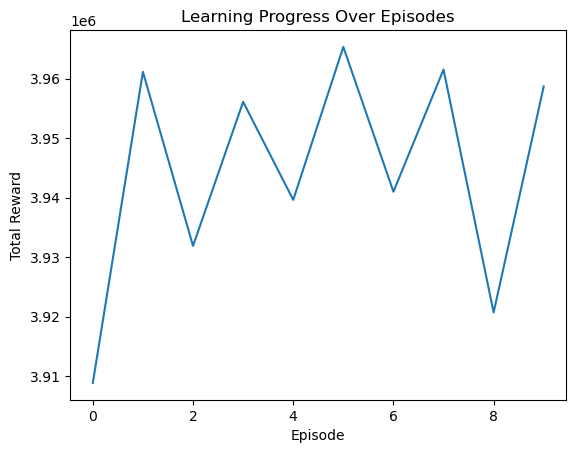

In [18]:
import matplotlib.pyplot as plt

# Additional parameters
num_episodes = 10  # Number of days to simulate
learning_rewards = []  # To track the sum of rewards for each episode

for episode in range(num_episodes):
    total_episode_reward = 0  # Sum of rewards for the current episode
    
    # Reset battery level at the start of the episode
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    
    for hour in range(1, total_hours - 1):  # Ensure we have a next state
        price_level = price_bins[hour]  # Current price level
        state_index = get_state_index(battery_level, price_level)
        
        action = choose_action(state_index)  # Choose action based on the policy
        
        # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
        reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
        total_episode_reward += reward
        
        # Update battery level based on action (simplified, without actual consumption or charging logic)
        battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
        
        next_price_level = price_bins[hour + 1]
        next_state_index = get_state_index(battery_level, next_price_level)
        
        # Update Q-table
        update_q_table(state_index, action, reward, next_state_index)
    
    learning_rewards.append(total_episode_reward)

# Plot learning progress
plt.plot(learning_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress Over Episodes')
plt.show()


In [36]:
# Assuming the inspection of the data shows it's suitable for our purposes, let's proceed with a simplified RL setup.
# For simplicity, this example will assume that we have merged the datasets on their timestamps and have a unified DataFrame.

# Importing additional libraries for Reinforcement Learning
# Note: In an actual implementation, we might use libraries like Stable Baselines3 or TensorFlow for the RL agent.
from sklearn.preprocessing import StandardScaler

# Placeholder for an RL environment class
class BatteryOptimizationEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.done = False
        self.action_space = 3  # Three actions: charge, discharge, hold
        self.state_space = self.data.shape[1]  # Number of features in the data
        self.state = None
        
    def reset(self):
        self.current_step = 0
        self.done = False
        self.state = self.data.iloc[self.current_step]
        return self.state
    
    def step(self, action):
        # Placeholder for the step function logic
        reward = 0
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
        self.state = self.data.iloc[self.current_step] if not self.done else None
        return self.state, reward, self.done, {}
    
    def render(self):
        # Placeholder for render function, which could visualize the state and actions over time
        pass

# Placeholder for a simple RL agent
class SimpleRlAgent:
    def __init__(self, env):
        self.env = env
    
    def train(self):
        # Placeholder for the training logic
        pass
    
    def act(self, state):
        # Placeholder for a policy, deciding action based on state
        return np.random.choice(self.env.action_space)

# Note: The above classes are placeholders and need to be filled in with actual logic.
# This includes defining how actions affect the state and calculating the reward based on electricity costs and battery operations.

# Example of how we might preprocess the data for the environment
def preprocess_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)
prices = pd.read_csv('C:/Users/volco/AdvancedBA/Data/prices.csv')
preprocessed_data = preprocess_data(prices)

# Setup the environment with preprocessed data
env = BatteryOptimizationEnv(preprocessed_data)

# Initialize the RL agent with the environment
agent = SimpleRlAgent(env)

# Start training
agent.train()

# Note: Actual data loading, preprocessing, and model training calls are omitted to prevent execution here.
# This setup provides a foundation for developing a more detailed RL model based on the specific needs and data.


ValueError: could not convert string to float: '2019-01-01 00:00:00'

In [37]:
# For a more concrete implementation, we need to fill in the logic for the step function and reward calculation.
# This requires a deeper understanding of the specific mechanics of battery charging/discharging, electricity costs, and how actions translate into state changes.
# Let's assume some simplified mechanics for the sake of this example.

# Enhancing the Environment with more detailed logic
class EnhancedBatteryOptimizationEnv(BatteryOptimizationEnv):
    def __init__(self, data, battery_capacity=100, battery_charge_rate=10, battery_discharge_rate=10):
        super().__init__(data)
        self.battery_capacity = battery_capacity  # Maximum capacity of the battery
        self.battery_state = 0  # Current charge level of the battery
        self.battery_charge_rate = battery_charge_rate  # Units the battery can charge per hour
        self.battery_discharge_rate = battery_discharge_rate  # Units the battery can discharge per hour
        
    def step(self, action):
        # Action 0: Hold, 1: Charge, 2: Discharge
        previous_state = self.state.copy()
        previous_battery_state = self.battery_state
        
        # Update battery state based on action
        if action == 1:  # Charge
            self.battery_state = min(self.battery_state + self.battery_charge_rate, self.battery_capacity)
        elif action == 2:  # Discharge
            self.battery_state = max(self.battery_state - self.battery_discharge_rate, 0)
        
        # Calculate reward
        # For simplicity, let's assume the reward is based on the cost savings from using the battery
        # Negative cost indicates expense, positive indicates savings or revenue
        cost_if_no_battery = previous_state['price'] * previous_state['load']
        cost_with_battery_action = previous_state['price'] * (previous_state['load'] - (self.battery_state - previous_battery_state))
        reward = cost_if_no_battery - cost_with_battery_action
        
        # Move to the next hour
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
        self.state = self.data.iloc[self.current_step] if not self.done else None
        
        return self.state, reward, self.done, {}

# Enhanced agent with a simple policy (for demonstration purposes)
class EnhancedRlAgent(SimpleRlAgent):
    def act(self, state):
        # Simple policy: if price is high, discharge; if low, charge; otherwise, hold
        if state['price'] > state['price'].mean():
            action = 2  # Discharge
        elif state['price'] < state['price'].mean():
            action = 1  # Charge
        else:
            action = 0  # Hold
        return action

# Assuming we have a preprocessed and integrated DataFrame 'preprocessed_data' ready for use
# For this example, let's create a dummy DataFrame to simulate this scenario
dummy_data = pd.DataFrame({
    'timestamp': pd.date_range(start='2021-01-01', periods=24, freq='H'),
    'load': np.random.uniform(low=0.5, high=1.5, size=24),
    'price': np.random.uniform(low=10, high=50, size=24),
    'generation': np.random.uniform(low=0, high=3, size=24)
})
dummy_data = preprocess_data(dummy_data.drop('timestamp', axis=1))

# Setup the enhanced environment with the dummy preprocessed data
env = EnhancedBatteryOptimizationEnv(dummy_data)

# Initialize the enhanced RL agent with the environment
agent = EnhancedRlAgent(env)

# Since the training loop and agent's decision-making logic are quite complex and depend on specific requirements,
# the provided setup acts as a foundation, demonstrating how you might structure the environment and agent.
# Actual training and policy refinement would require a more sophisticated approach, possibly using deep learning for policy approximation.

# Note: The actual training loop and detailed decision-making logic are placeholders and need to be developed further based on specific project needs.


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming a simple neural network for policy approximation
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.network(x)

# Simplified training loop
def train_agent(env, agent, episodes=1000):
    optimizer = optim.Adam(agent.policy_network.parameters(), lr=1e-2)
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
            action_probs = agent.policy_network(state_tensor)
            action = torch.multinomial(action_probs, 1).item()
            next_state, reward, done, _ = env.step(action)
            
            # Assume a simple reward-to-go calculation for updating the policy
            # In practice, would use a more sophisticated approach like policy gradients
            loss = -torch.log(action_probs[0, action]) * reward  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            state = next_state
